# Day 19 – Clustering (KMeans)
### Market Segmentation in SaaS Data

We’ll use **KMeans clustering** to group customers into segments based on their engagement and billing behaviors.

#### Goals:
- Understand unsupervised segmentation
- Use Elbow and Silhouette methods to find optimal K
- Visualize clusters using PCA
- Generate actionable business insights from clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import joblib
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load and Preprocess Dataset

In [2]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select relevant behavioral & billing features
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df[features], drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)
X_scaled[:5]

array([[-1.28024804, -1.16169394, -0.99419409, -0.88689648, -0.52513044,
        -0.52513044, -0.63374636, -0.52513044, -0.63926039, -0.5253508 ,
         1.40476387, -0.54360352],
       [ 0.06430269, -0.26087792, -0.17373982, -0.88689648, -0.52513044,
        -0.52513044,  1.57791834, -0.52513044, -0.63926039, -0.5253508 ,
        -0.71186341,  1.83957601],
       [-1.23950408, -0.36392329, -0.95964911, -0.88689648, -0.52513044,
        -0.52513044,  1.57791834, -0.52513044, -0.63926039, -0.5253508 ,
        -0.71186341,  1.83957601],
       [ 0.51248626, -0.74785042, -0.19524771, -0.88689648, -0.52513044,
        -0.52513044,  1.57791834, -0.52513044,  1.56430778, -0.5253508 ,
        -0.71186341, -0.54360352],
       [-1.23950408,  0.19617818, -0.94045745,  1.12752731, -0.52513044,
        -0.52513044, -0.63374636, -0.52513044, -0.63926039, -0.5253508 ,
         1.40476387, -0.54360352]])

## 2. Determine Optimal K (Elbow Method & Silhouette Score)

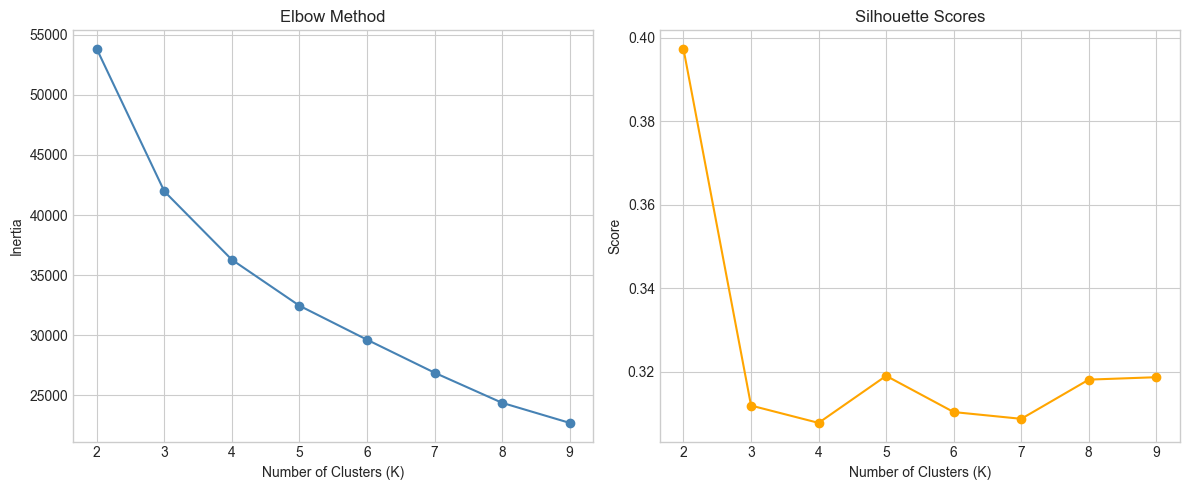

Best K (by Silhouette Score): 2


In [3]:
inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K_range, inertias, 'o-', color='steelblue')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters (K)')
ax[0].set_ylabel('Inertia')

# Plot Silhouette Scores
ax[1].plot(K_range, sil_scores, 'o-', color='orange')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of Clusters (K)')
ax[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(sil_scores)]
print(f'Best K (by Silhouette Score): {best_k}')

## 3. Apply KMeans with Optimal K

In [4]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

print('Cluster distribution:')
print(df['Cluster'].value_counts())

Cluster distribution:
Cluster
0    5512
1    1520
Name: count, dtype: int64


## 4. Visualize Clusters using PCA (2D Projection)

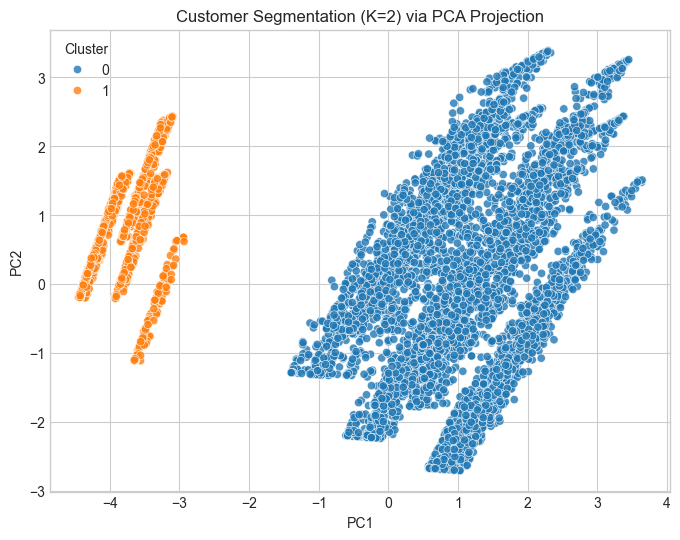

In [5]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)
df['PC1'], df['PC2'] = pca_features[:, 0], pca_features[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='tab10', alpha=0.8)
plt.title(f'Customer Segmentation (K={best_k}) via PCA Projection')
plt.show()

## 5. Cluster Profiling (Summary Stats)

In [8]:
cluster_summary = df.groupby('Cluster')[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].mean().round(2)
cluster_summary

,tenure,MonthlyCharges,TotalCharges,Churn
Cluster,,,,
0,32.91,76.86,2729.51,0.32
1,30.67,21.08,665.22,0.07


### 💡 Business Interpretation
- Cluster 0: Low tenure, high monthly spend → **At-risk customers**.
- Cluster 1: Long tenure, moderate cost → **Loyal base**.
- Cluster 2: Moderate tenure, premium services → **Upsell potential**.

## 6. Save Clustering Model for Production

In [9]:
joblib.dump(kmeans, 'kmeans_segments.pkl')
df.to_csv('clustered_customers.csv', index=False)
print('✅ Saved KMeans model (kmeans_segments.pkl) and segmented dataset (clustered_customers.csv)')

✅ Saved KMeans model (kmeans_segments.pkl) and segmented dataset (clustered_customers.csv)


## ✅ Summary
- Used **KMeans** to segment SaaS customers by behavior.
- Identified optimal clusters using **Elbow** and **Silhouette** methods.
- Visualized segments using **PCA**.
- Generated cluster-level business insights.
- Saved results for future integration.

**Deliverable:** `day19_clustering_market_segmentation.ipynb`